## Desafío - Árboles de Regresión
* Para realizar este desafío debes haber revisado la lectura y videos correspondiente a la unidad.
* Crea una carpeta de trabajo y guarda todos los archivos correspondientes (notebook y csv).
* Una vez terminado el desafío, comprime la carpeta y sube el .zip a la seccióncorrespondiente.

### Descripción
* Para esta sesión trabajaremos con una base de datos sobre los precios de inmuebles en la ciudad de Ames, Iowa. La base se compone de 2930 registros y contiene un gran número de atributos.
* Nuestro objetivo es generar un modelo que prediga de forma adecuada los precios de inmuebles, medidos con la variable Sale_Price.

#### Ejercicio 1: Preparación del ambiente de trabajo
* Importe las librerías clásicas a utilizar.
* Para este ejercicio implementaremos árboles de regresión, por lo que deberá importar la clase DecisionTreeRegressor.
* De manera adicional importe las funciones y clases necesarias para generar un desempeño de métricas en problemas de regresión, división de muestras y búsqueda de grilla con validación cruzada.
* Elimine la columna 'Unnamed: 0' cuando cargue los datos.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import warnings

warnings.filterwarnings(action='ignore')

In [2]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import  mean_squared_error, median_absolute_error, r2_score

In [3]:
df = pd.read_csv('ames_housing.csv').drop(columns=['Unnamed: 0'])
df.head()

,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,Utilities,Lot_Config,...,Fence,Misc_Feature,Misc_Val,Mo_Sold,Year_Sold,Sale_Type,Sale_Condition,Sale_Price,Longitude,Latitude
0,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,141,31770,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,No_Fence,None,0,5,2010,WD,Normal,215000,-93.619754,42.054035
1,One_Story_1946_and_Newer_All_Styles,Residential_High_Density,80,11622,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,...,Minimum_Privacy,None,0,6,2010,WD,Normal,105000,-93.619756,42.053014
2,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,81,14267,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,No_Fence,Gar2,12500,6,2010,WD,Normal,172000,-93.619387,42.052659
3,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,93,11160,Pave,No_Alley_Access,Regular,Lvl,AllPub,Corner,...,No_Fence,None,0,4,2010,WD,Normal,244000,-93.617320,42.051245
4,Two_Story_1946_and_Newer,Residential_Low_Density,74,13830,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Inside,...,Minimum_Privacy,None,0,3,2010,WD,Normal,189900,-93.638933,42.060899


#### Ejercicio 2: Feature engineering
* Identifique si el dtype de cada pd.Serie en nuestra base de datos se considera 'object' o no. Para todas las variables que sean 'object', realice lo siguiente:
    1. Genere una recodificación $K-1$ en cada variable. Para efectos prácticos sólo necesitan eliminar una de las categorías, no se concentren en especificar la categoría a eliminar. Pueden utilizar la función pd.get_dummies con la opción drop_first para ello.
    2. Utilizando el método pd.concat , concatene a los atributos creados en la base de datos. 


In [4]:
object_series = list(filter(lambda colname: df[colname].dtype == np.dtype('object'), df.columns))

print('Son ', len(object_series), 'variables de tipo object')

df_dummies = pd.get_dummies(df, drop_first=True, columns=object_series)
df_dummies.head()

Son  46 variables de tipo object


,Lot_Frontage,Lot_Area,Year_Built,Year_Remod_Add,Mas_Vnr_Area,BsmtFin_SF_1,BsmtFin_SF_2,Bsmt_Unf_SF,Total_Bsmt_SF,First_Flr_SF,...,Sale_Type_ConLw,Sale_Type_New,Sale_Type_Oth,Sale_Type_VWD,Sale_Type_WD,Sale_Condition_AdjLand,Sale_Condition_Alloca,Sale_Condition_Family,Sale_Condition_Normal,Sale_Condition_Partial
0,141,31770,1960,1960,112,2,0,441,1080,1656,...,0,0,0,0,1,0,0,0,1,0
1,80,11622,1961,1961,0,6,144,270,882,896,...,0,0,0,0,1,0,0,0,1,0
2,81,14267,1958,1958,108,1,0,406,1329,1329,...,0,0,0,0,1,0,0,0,1,0
3,93,11160,1968,1968,0,1,0,1045,2110,2110,...,0,0,0,0,1,0,0,0,1,0
4,74,13830,1997,1998,0,3,0,137,928,928,...,0,0,0,0,1,0,0,0,1,0


#### Ejercicio 3: Primer modelo
* Genere muestras de entrenamiento y validación con 'Sale_Price' como vector objetivo y los atributos de la base de datos como matriz.
* Recuerde definir el porcentaje de casos en la muestra de validación y una semilla pseudoaleatoria.
* Posteriormente, entrene un árbol de regresión en la muestra de entrenamiento sin modificar los hiperparámetros. Reporte las principales métricas de desempeño.
* Comente sobre el desempeño.

In [5]:
y = np.log(df_dummies['Sale_Price'])
X = df_dummies.loc[:, df_dummies.columns != 'Sale_Price']

X_train, X_test, y_train, y_test, = train_test_split(X, y, test_size = 0.33, random_state = 19082019)

In [6]:
dec_tree = DecisionTreeRegressor(random_state = 19082019).fit(X_train, y_train)

In [7]:
y_hat = dec_tree.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_hat).round(5))
print("MAE:", median_absolute_error(y_test, y_hat).round(5))
print("R2:", r2_score(y_test, y_hat).round(5))

MSE: 0.04306
MAE: 0.09361
R2: 0.73385


El desempeño no fue tan malo, de hecho MSE es bajo y el R2 es mayor a 50%

#### Ejercicio 4: Importancia relativa
* Implemente el método plot_importance utilizado en la lectura para reportar la importancia relativa de los atributos.
* Comente sobre cuáles son los principales 10 atributos que afectan la predicción de Sale_Price.
* Separe éstos 10 atributos en una nueva base de datos, junto con el vector objetivo.

In [8]:
def plot_importance(fit_model, feat_names):
    tmp_importance = fit_model.feature_importances_
    
    importance_df = pd.DataFrame(tmp_importance, index=feat_names, columns=['value'])
    importance_df = importance_df.sort_values(by='value', ascending=False).head(10)
    plt.title('Feature importance')
    importance_df['value'].plot.barh()
    return importance_df.index

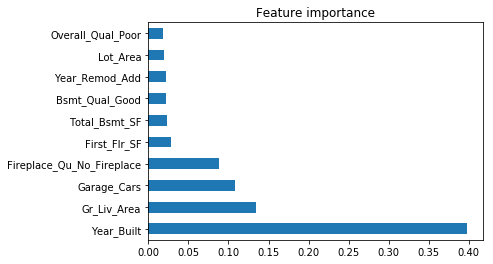

In [9]:
important_features = plot_importance(dec_tree, X.columns)

In [10]:
df_important = df_dummies[list(important_features) + ['Sale_Price']]
df_important.head()

,Year_Built,Gr_Liv_Area,Garage_Cars,Fireplace_Qu_No_Fireplace,First_Flr_SF,Total_Bsmt_SF,Bsmt_Qual_Good,Year_Remod_Add,Lot_Area,Overall_Qual_Poor,Sale_Price
0,1960,1656,2,0,1656,1080,0,1960,31770,0,215000
1,1961,896,1,1,896,882,0,1961,11622,0,105000
2,1958,1329,1,1,1329,1329,0,1958,14267,0,172000
3,1968,2110,2,0,2110,2110,0,1968,11160,0,244000
4,1997,1629,2,0,928,928,1,1998,13830,0,189900


#### Ejercicio 5: Refactorización del modelo y pickling
* En función de los atributos seleccionados en el ejercicio anterior, vuelva a generar conjuntos de entrenamiento y validación.
* Dentro de los datos de entrenamiento genere una búsqueda de grila con GridSearchCV utilizando los siguientes hiperparámetros:
    * Máximo de atributos: Evalúe todos los posibles atributos.
    * Máximo de profundidad: entre 1 a 32.
    * Validaciones cruzadas : 5.
* Reporte la mejor combinación de hiperparámetros y su desempeño asociado. Compare el desempeño en la muestra de validación con el modelo por defecto.

#### Pickling
* Ahora generaremos una serialización de nuestro modelo depurado, y nuestros conjuntos de entrenamiento y validación depurados. Para ello importe el módulo pickle.
* pickle contiene la función dump , que permite guardar el modelo desarrollado. La forma canónica para desarrollar el pickling es:

```python  
pickle.dump(<OBJETO_CON_EL_MODELO>, open('nombre-apellido-actividad07.sav','wb'))
```

* Envíe su modelo y conjuntos de entrenamiento a un compañero.

In [11]:
y = np.log(df_important['Sale_Price'])
X = df_important.loc[:, df_important.columns != 'Sale_Price']

X_train, X_test, y_train, y_test, = train_test_split(X, y, test_size = 0.33, random_state = 19082019)

In [12]:
params = {
    'max_depth': np.linspace(1, 32, 32),
    'max_features': list(range(1, X_train.shape[1]))
}

cv = GridSearchCV(DecisionTreeRegressor(random_state = 19082019), params, cv=5)

In [13]:
result = cv.fit(X_train, y_train)

In [14]:
result.best_params_

best_max_depth = result.best_params_['max_depth']
best_max_features = result.best_params_['max_features']
print('La mejor combinación de hiperparámetros es max_depth = {} y max_features = {}'.format(best_max_depth, best_max_features))

La mejor combinación de hiperparámetros es max_depth = 8.0 y max_features = 7


In [15]:
y_hat = result.best_estimator_.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_hat).round(5))
print("MAE:", median_absolute_error(y_test, y_hat).round(5))
print("R2:", r2_score(y_test, y_hat).round(5))

MSE: 0.04107
MAE: 0.09584
R2: 0.7461


Podemos ver que este modelo tiene mejores métricas, ya que el MSE y MAE son menores mientras que el R2 es mayor.

|  Métrica | Modelo 1  | Modelo 2  |
|---|---|---|
|  MSE | 0.04306 | 0.04107  |
|  MAE | 0.09361 | 0.09584  |
|  R2  | 0.73385 | 0.7461  |

In [16]:
import pickle

In [17]:
pickle.dump(result.best_estimator_, open('nicolas-gomez-actividad07.sav','wb'))

In [18]:
def export_df_with_target(name, X, y):
    X_copy = X_train.copy()
    X_copy['y'] = y
    X_copy.to_csv(name)

In [19]:
export_df_with_target('test.csv', X_test, y_test)
export_df_with_target('train.csv', X_train, y_train)

In [20]:
with open('./model_francisco_sanchez/francisco-sanchez-actividad07.sav', 'rb') as pickle_file:
    X_test = pd.read_csv('./model_francisco_sanchez/x_test.csv')
    y_test = pd.read_csv('./model_francisco_sanchez/y_test.csv')
    model = pickle.load(pickle_file)
    y_hat = model.predict(X_test)
    print("Test MSE: ", mean_squared_error(y_test, y_hat))
    print("Test MAE: ", median_absolute_error(y_test, y_hat))
    print("Test R2: ", r2_score(y_test, y_hat))

Test MSE:  0.03966900201022896
Test MAE:  0.09665318127162337
Test R2:  0.7547857352588414
